In [1]:
# --- Importing useful libraries ---
import numpy as np
from scipy.stats import gamma, multivariate_normal, norm
import pandas as pd
import math as math
#import pymc as pm
import emcee

# --- Pretty plots ---
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

cmap = ListedColormap(sns.color_palette("rocket", 256))

sns.set_palette("mako")

rc('axes', axisbelow = True)
rc('font', **{'family': 'serif', 'serif': ["Palatino"]})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Palatino'
plt.rcParams['mathtext.it'] = 'Palatino:italic'
plt.rcParams['mathtext.bf'] = 'Palatino:bold'
rc('text', usetex=True)

import arviz as az
import corner
# --- Random seed ---
np.random.seed(314159)

In [2]:
### LOAD DATASET
file_path = 'HyperLeda_galaxies_and_errors.txt' 
data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=['objname', 'mod0', 'e_mod0', 'vgsr', 'v', 'e_v', 'f_astrom', 'l2', 'b2'])

### CONVERT COLUMNS TO NUMERIC, SETTING ERRORS = 'coerce' & DROP NaN
data['mod0'] = pd.to_numeric(data['mod0'], errors='coerce')
data['e_mod0'] = pd.to_numeric(data['e_mod0'], errors='coerce')
data['vgsr'] = pd.to_numeric(data['vgsr'], errors='coerce')
data['v'] = pd.to_numeric(data['v'], errors='coerce')
data['e_v'] = pd.to_numeric(data['e_v'], errors='coerce')
data['f_astrom'] = pd.to_numeric(data['f_astrom'], errors='coerce')
data['l2'] = pd.to_numeric(data['l2'], errors='coerce')
data['b2'] = pd.to_numeric(data['b2'], errors='coerce')

data = data.dropna(subset=['mod0', 'e_mod0', 'vgsr', 'v', 'e_v', 'f_astrom', 'l2', 'b2'])

### CALCULATE LUMINOSITY DISTANCE (DL) AND THE ERROR (e_DL) FROM DISTANCE MODULUS (mod0), (e_mod0)
data['distance_mpc'] = 10 ** (0.2 * data['mod0'] - 5)
data['distance_error'] = np.abs(data['distance_mpc'] * 0.2 * np.log(10) * data['e_mod0'])

### ERRORS IN GALACTIC COODINATE ANGLES FROM f_astrom values
arcsec_errors = {
    -1: 0.1,    # precision about 0.1 arcsec
     0: 1,      # 1 arcsec
     1: 10,     # 10 arcsec
     2: 100,    # 100 arcsec (1 arcmin)
     3: 1000    # 1000 arcsec (10 arcmin)
}

### CONVERT TO RADIANS 
data['astrom_error_rad'] = data['f_astrom'].map(arcsec_errors) * (np.pi / (180 * 3600))

### CALCULATE ERROS IN l2 AND b2 DUE TO ASTROMETRIC PRECISION 
data['error_l2'] = np.cos(data['b2'] * np.pi / 180) * data['astrom_error_rad']
data['error_b2'] = data['astrom_error_rad']

### CALCULATE THE PROPAGATED ERROR IN vgsr (e_vgsr)
data['e_vgsr'] = np.sqrt(
    data['e_v']**2 + 
    (232 * np.cos(data['l2'] * np.pi / 180) * np.cos(data['b2'] * np.pi / 180) * data['error_l2'])**2 +
    (232 * np.sin(data['l2'] * np.pi / 180) * np.sin(data['b2'] * np.pi / 180) * data['error_b2'])**2 +
    (9 * np.sin(data['l2'] * np.pi / 180) * np.cos(data['b2'] * np.pi / 180) * data['error_l2'])**2 +
    (9 * np.cos(data['l2'] * np.pi / 180) * np.sin(data['b2'] * np.pi / 180) * data['error_b2'])**2 +
    (7 * np.cos(data['b2'] * np.pi / 180) * data['error_b2'])**2
)

### CHECK: VERIFY WHETHER FORMULA FOR vgsr MATCH THE GIVEN DATA 
data['vgsr_calculated'] = data['v'] + 232 * np.sin(data['l2'] * np.pi / 180) * np.cos(data['b2'] * np.pi / 180) \
                          + 9 * np.cos(data['l2'] * np.pi / 180) * np.cos(data['b2'] * np.pi / 180) \
                          + 7 * np.sin(data['b2'] * np.pi / 180)
data['vgsr_match'] = np.isclose(data['vgsr'], data['vgsr_calculated'], atol=1e-1)

## Plot dataset

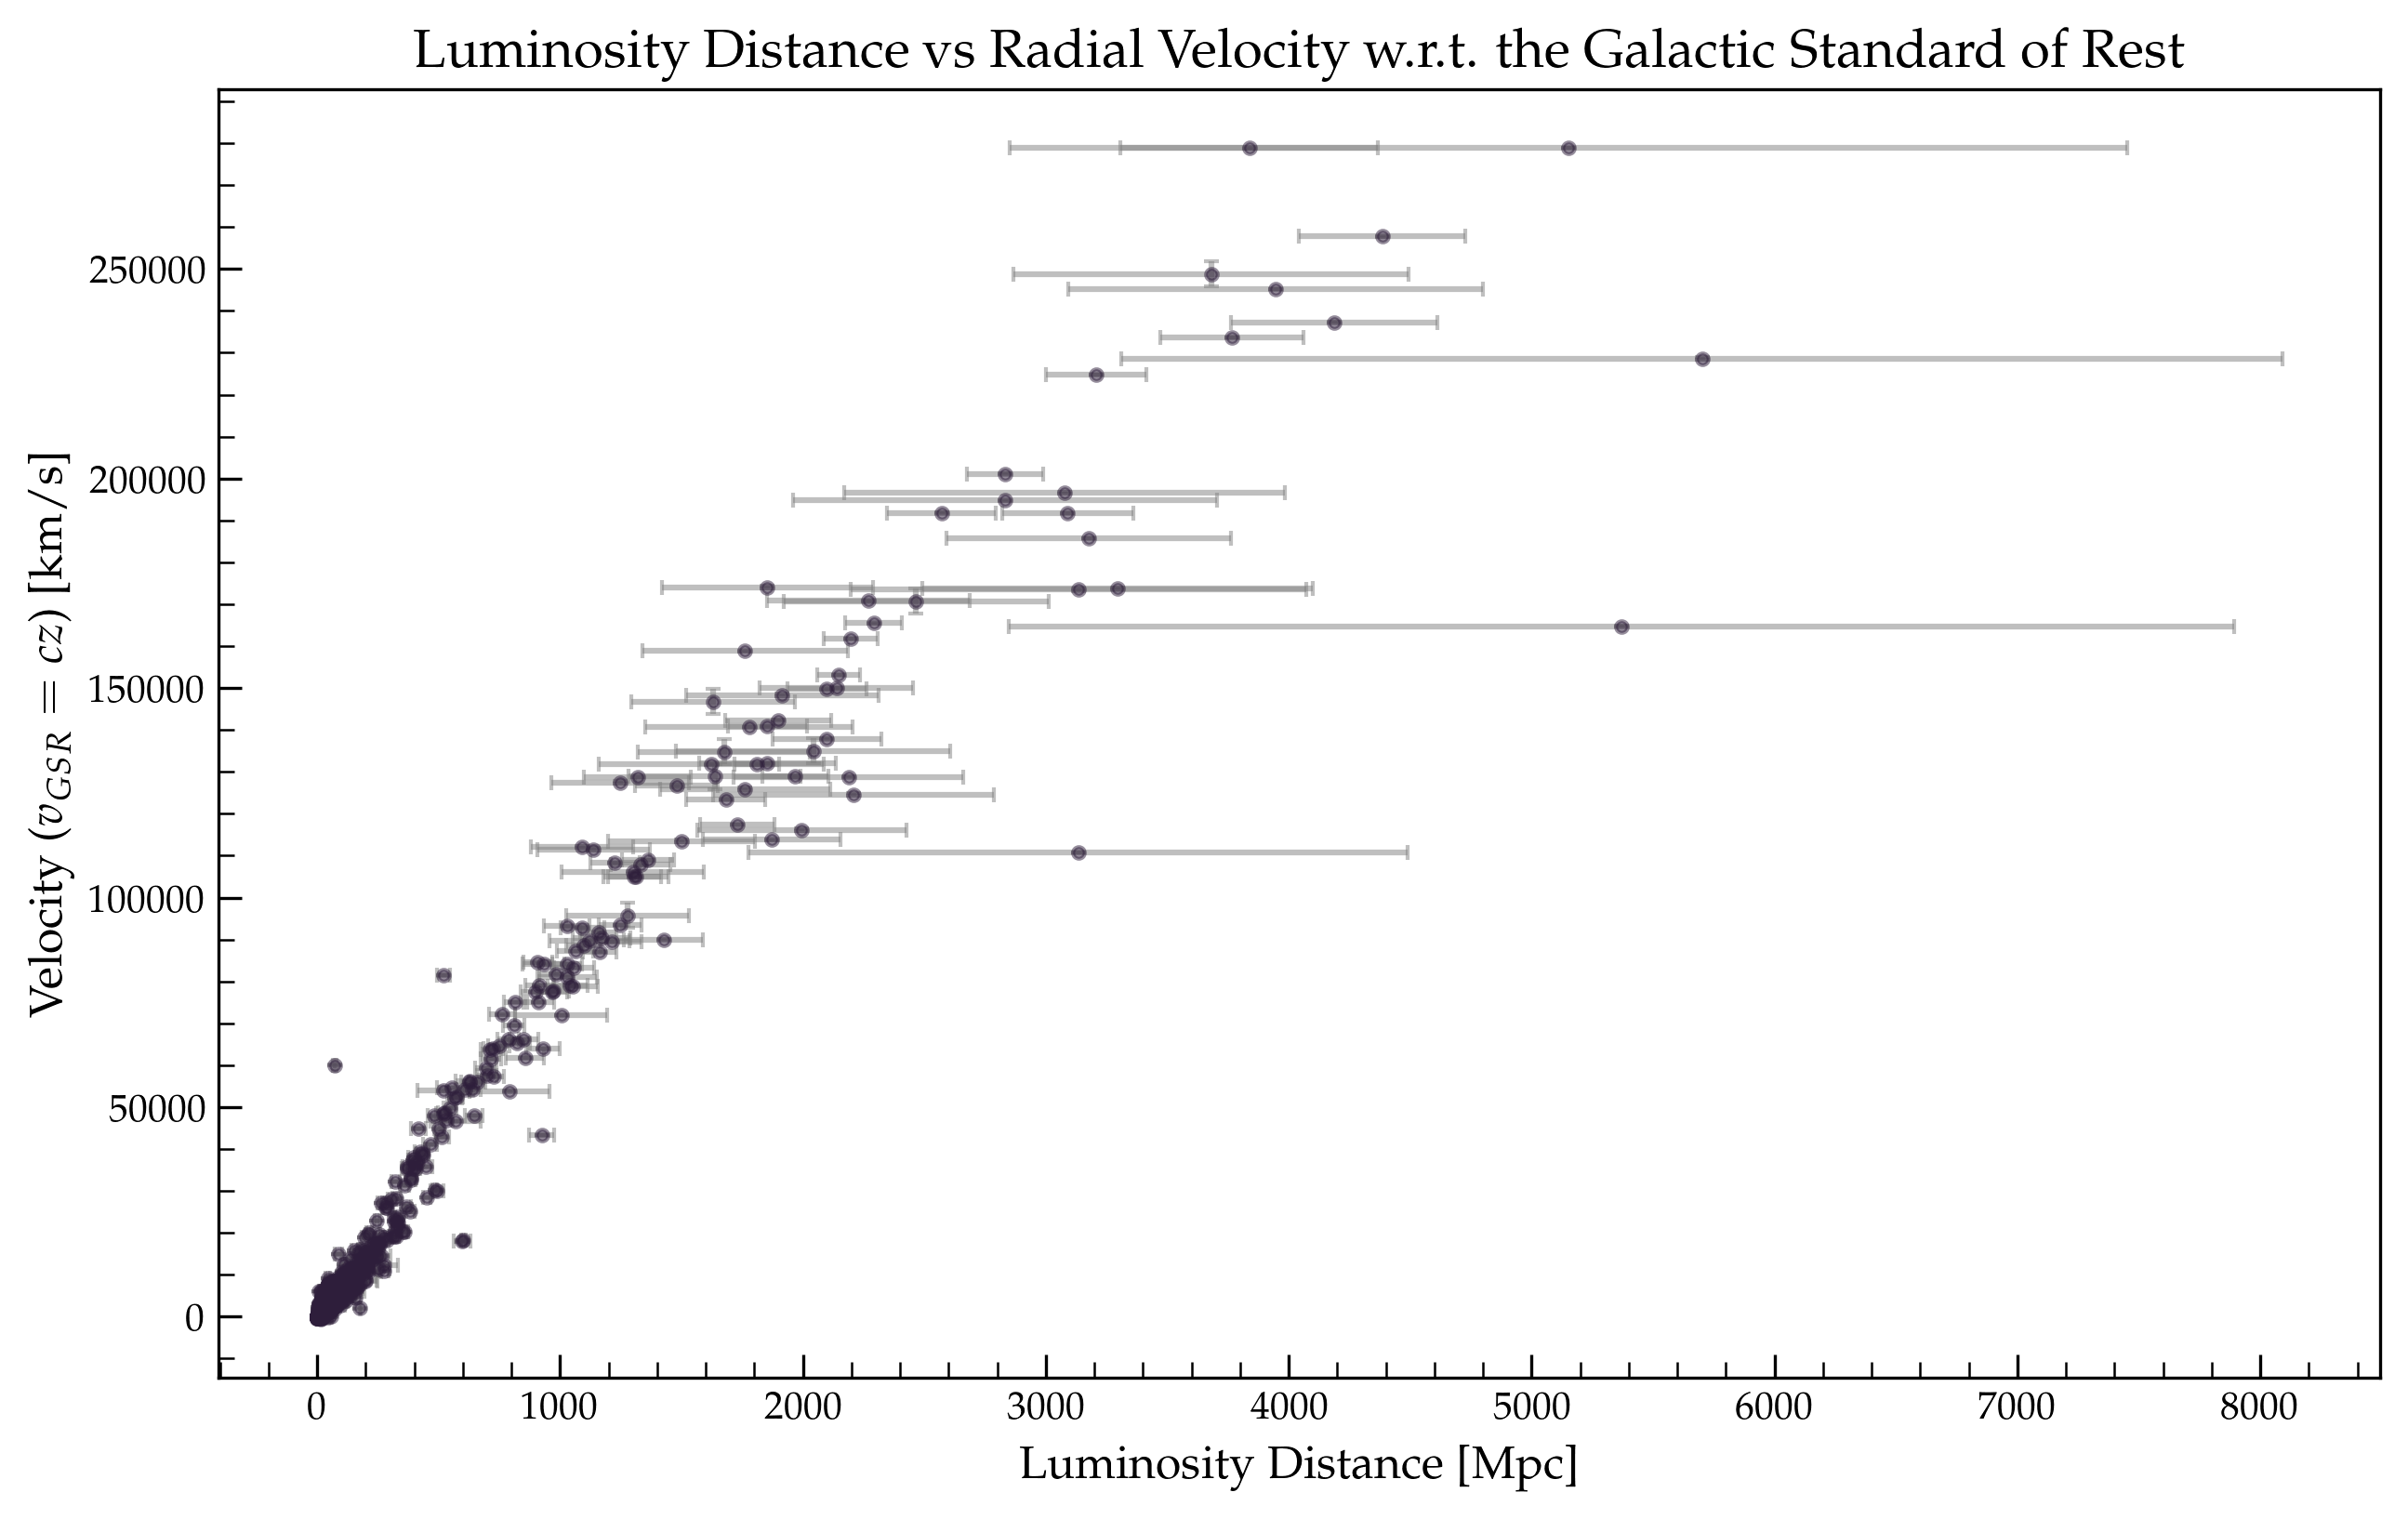

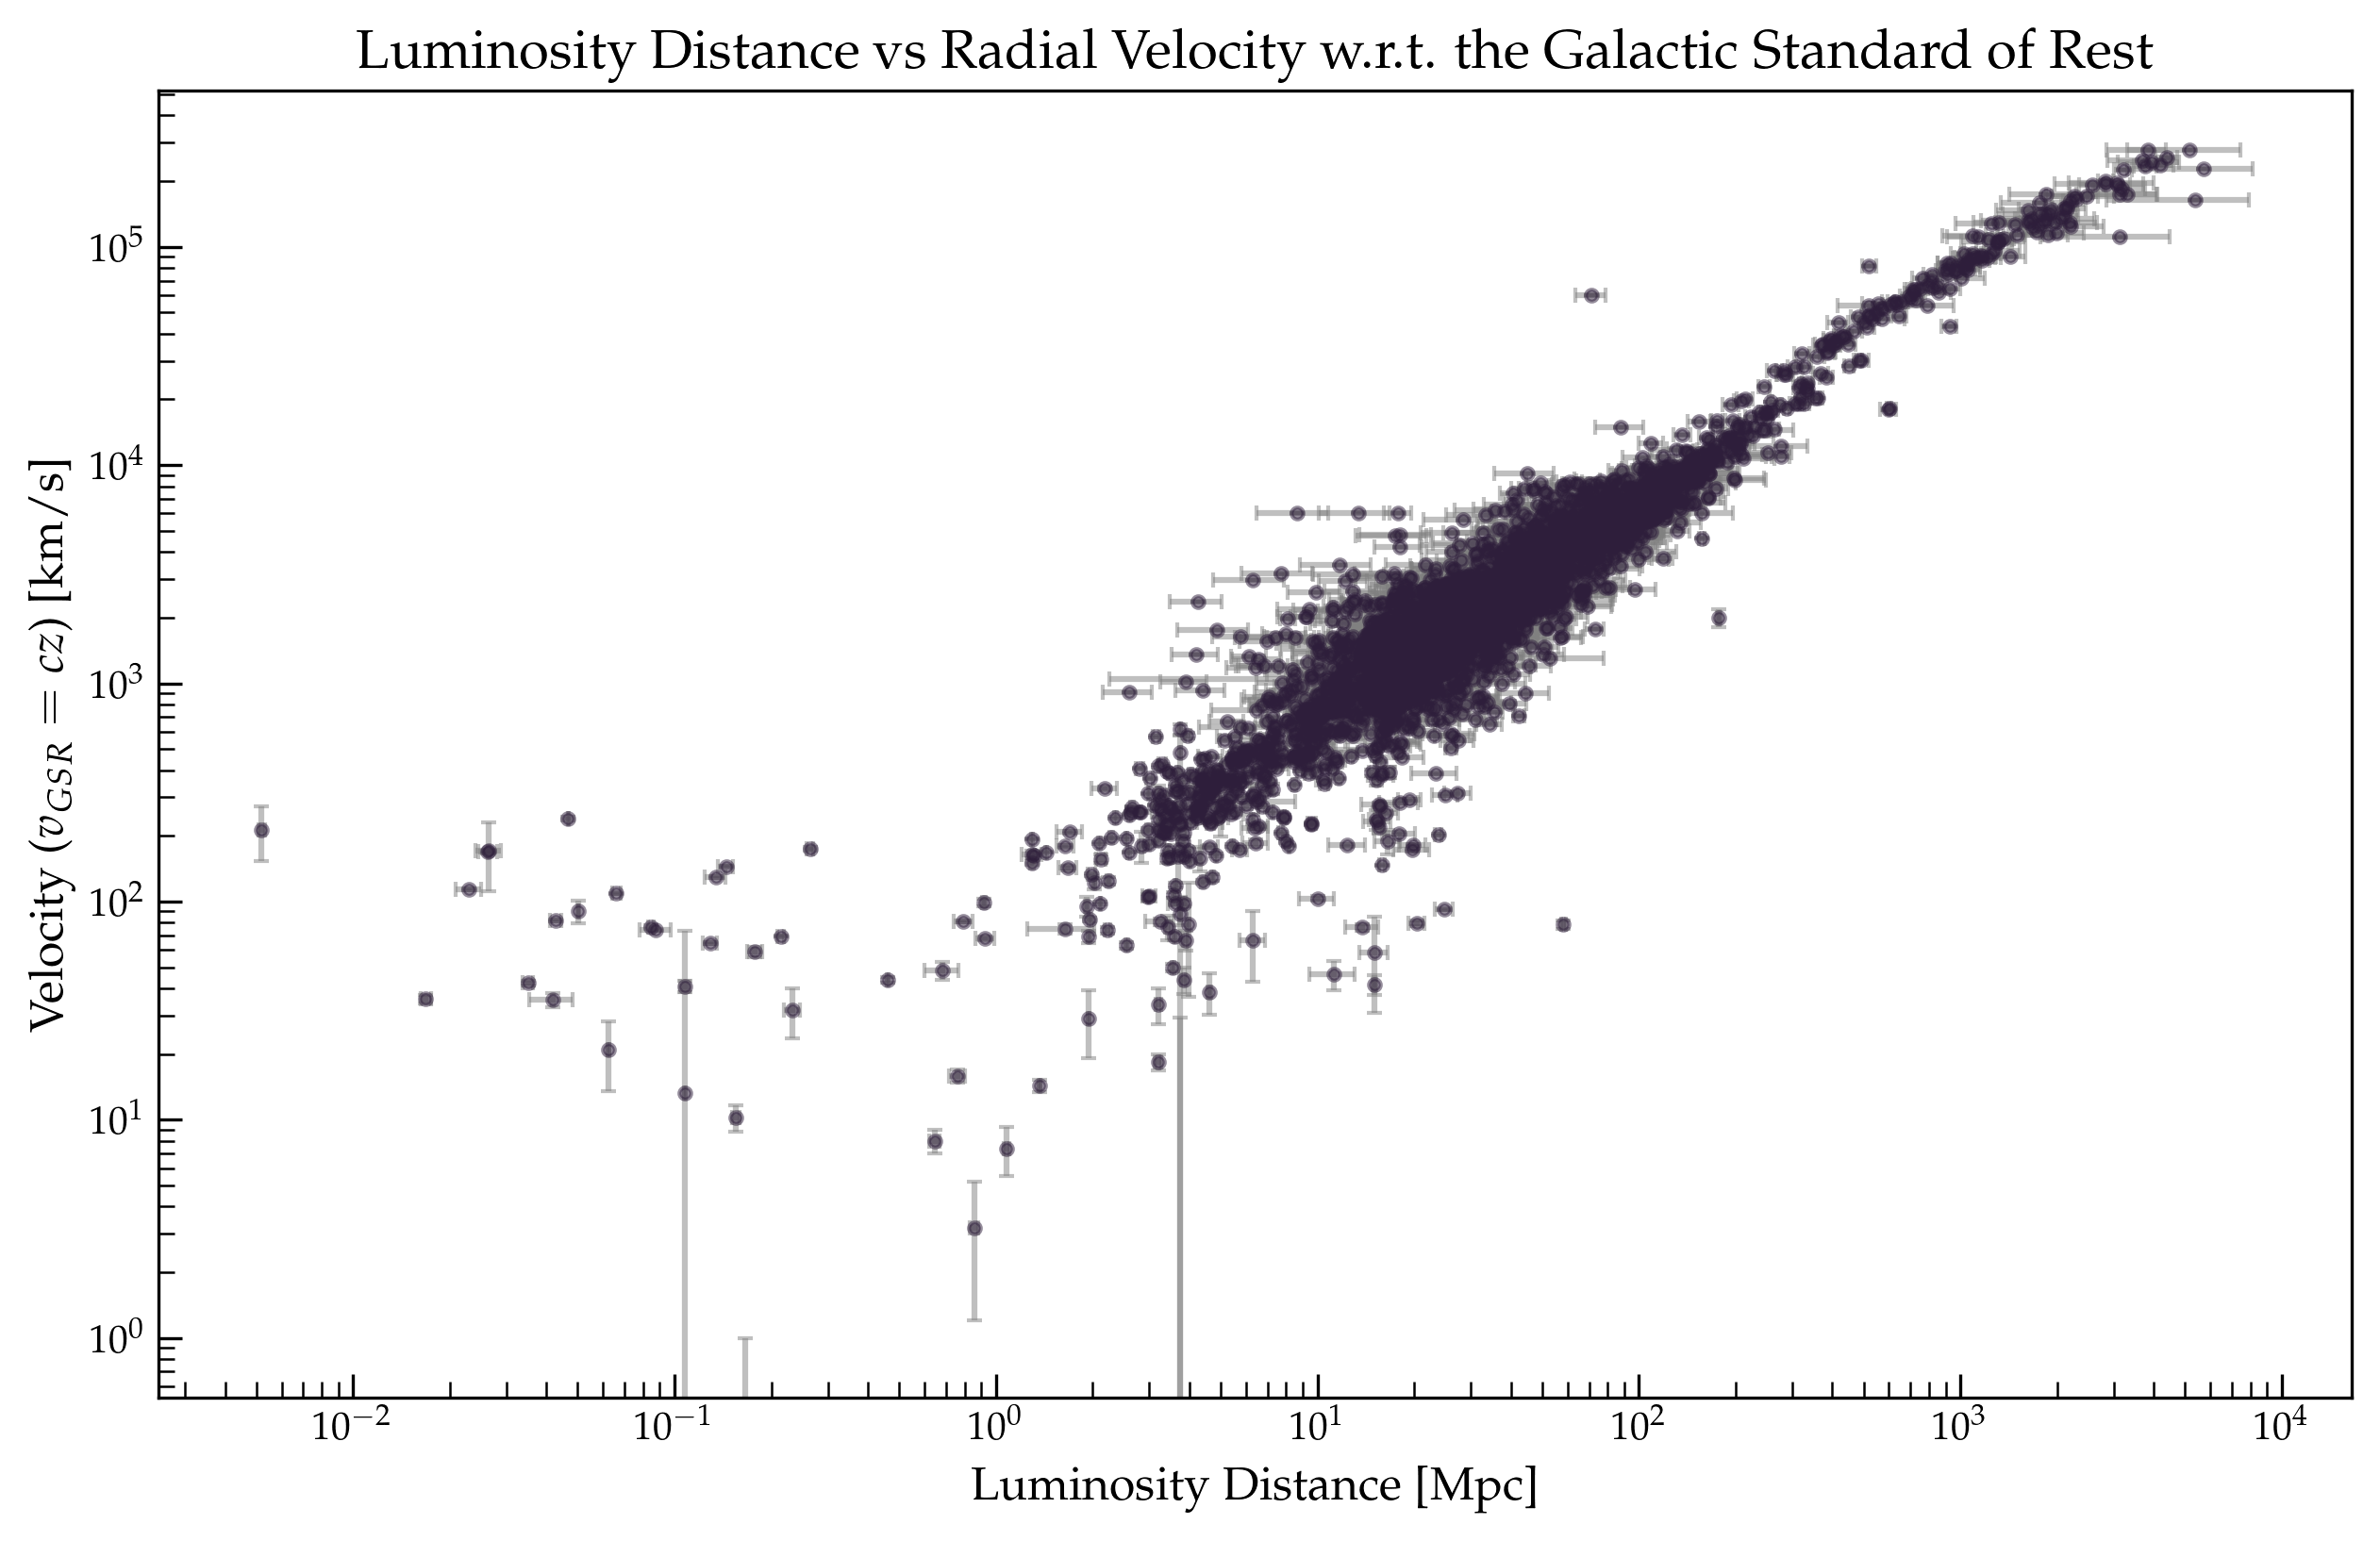

In [3]:
plt.figure(dpi=300, figsize=(10, 6))
plt.errorbar(data['distance_mpc'], data['vgsr'], 
             xerr=data['distance_error'], yerr=data['e_vgsr'], 
             fmt='o', markersize=3, alpha=0.5, ecolor='gray', capsize=2)
plt.xlabel(r'Luminosity Distance [Mpc]', fontsize=12)
plt.ylabel(r'Velocity ($v_{GSR} = c z$) [km/s]', fontsize=12)
plt.title(r'Luminosity Distance vs Radial Velocity w.r.t. the Galactic Standard of Rest', fontsize=14)
plt.tick_params(axis='both', which='major', direction='in', length=6)
plt.tick_params(axis='both', which='minor', direction='in', length=4)
plt.minorticks_on()

plt.show()

plt.figure(dpi=300, figsize=(10, 6))
plt.errorbar(data['distance_mpc'], data['vgsr'], 
             xerr=data['distance_error'], yerr=data['e_vgsr'], 
             fmt='o', markersize=3, alpha=0.5, ecolor='gray', capsize=2)
plt.xlabel(r'Luminosity Distance [Mpc]', fontsize=12)
plt.ylabel(r'Velocity ($v_{GSR} = c z$) [km/s]', fontsize=12)
plt.title(r'Luminosity Distance vs Radial Velocity w.r.t. the Galactic Standard of Rest', fontsize=14)
plt.tick_params(axis='both', which='major', direction='in', length=6)
plt.tick_params(axis='both', which='minor', direction='in', length=4)
plt.minorticks_on()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
data

,objname,mod0,e_mod0,vgsr,v,e_v,f_astrom,l2,b2,distance_mpc,distance_error,astrom_error_rad,error_l2,error_b2,e_vgsr,vgsr_calculated,vgsr_match
1,NGC5698,34.019,0.049,3734.2,3636.9,12.2,0.0,66.760516,65.170552,63.650233,1.436289,0.000005,0.000002,0.000005,12.2,3734.260858,True
2,UGC09556,33.710,0.400,2462.2,2314.4,4.4,0.0,100.055278,51.149563,55.207744,10.169642,0.000005,0.000003,0.000005,4.4,2462.161585,True
3,UGC09612,35.980,0.040,10962.8,10839.9,2.4,0.0,77.656824,59.250330,157.036280,2.892715,0.000005,0.000002,0.000005,2.4,10962.776476,True
4,UGC09638,32.630,0.400,2426.7,2278.4,4.0,0.0,97.116657,51.430526,33.573761,6.184515,0.000005,0.000003,0.000005,4.0,2426.706909,True
5,PGC214352,35.850,0.050,10112.1,10060.0,3.2,0.0,20.171881,58.606192,147.910839,3.405773,0.000005,0.000003,0.000005,3.2,10112.050538,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,UGC08742,32.250,0.400,2332.6,2258.8,5.3,0.0,80.760640,73.076827,28.183829,5.191653,0.000005,0.000001,0.000005,5.3,2332.574031,True
4234,NGC5313,33.360,0.347,2616.8,2540.0,2.8,0.0,83.413090,72.361052,46.989411,7.508880,0.000005,0.000001,0.000005,2.8,2616.819799,True
4235,NGC5337,33.510,0.430,2204.2,2126.9,2.4,0.0,81.579513,72.175578,50.350061,9.970436,0.000005,0.000001,0.000005,2.4,2204.217329,True
4236,UGC09245,31.146,0.357,2017.9,1886.0,1.8,0.0,99.436273,56.309753,16.951183,2.786852,0.000005,0.000003,0.000005,1.8,2017.955522,True


In [19]:
### MODEL 1: BAYESIAN LINEAR REGRESSION WITHOUT ERRORS
with pm.Model() as model_no_errors:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = intercept + slope * data['distance_mpc']
    vgsr_obs = pm.Normal('vgsr_obs', mu=mu, sigma=sigma, observed= data['vgsr'])
    trace_no_errors = pm.sample(2000, tune=1000, return_inferencedata=True)

### MODEL 2: BAYESIAN LINEAR REGRESSION WITH ERRORS
with pm.Model() as model_with_errors:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=50, sigma=20)
    intrinsic_sigma = pm.HalfNormal('intrinsic_sigma', sigma=20)
    
    dist_true = pm.Normal('dist_true', mu=data['distance_mpc'], sigma= data['distance_error'], shape=len(data['distance_mpc']))
    mu = intercept + slope * dist_true
    total_sigma = pm.math.sqrt(intrinsic_sigma**2 + data['e_vgsr']**2)
    vgsr_obs = pm.Normal('vgsr_obs', mu=mu, sigma=total_sigma, observed=data['vgsr'])
    trace_with_errors = pm.sample(12000, tune=1000, return_inferencedata=True)

### SUMMARIZE RESULTS
summary_no_errors = az.summary(trace_no_errors, hdi_prob=0.95)
summary_with_errors = az.summary(trace_with_errors, hdi_prob=0.95)

print("Model Without Errors:")
print(summary_no_errors)

print("\nModel With Errors:")
print(summary_with_errors)

NameError: name 'pm' is not defined

In [8]:
for i, param_name in enumerate(trace_with_errors.posterior.keys()):
    print(i, param_name)

for i, param_name in enumerate(trace_no_errors.posterior.keys()):
    print(i, param_name)

0 intercept
1 slope
2 dist_true
3 intrinsic_sigma
0 intercept
1 slope
2 sigma


/home/feradofogo/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (100) is smaller than the number of variables to plot (4059) in plot_posterior, generating only 100 plots
  warnings.warn(


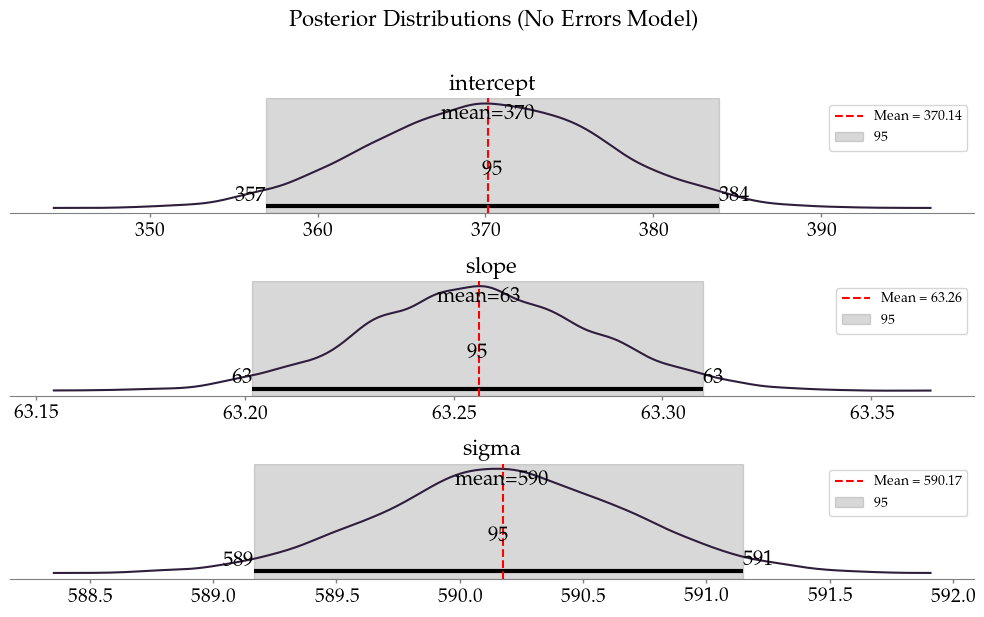

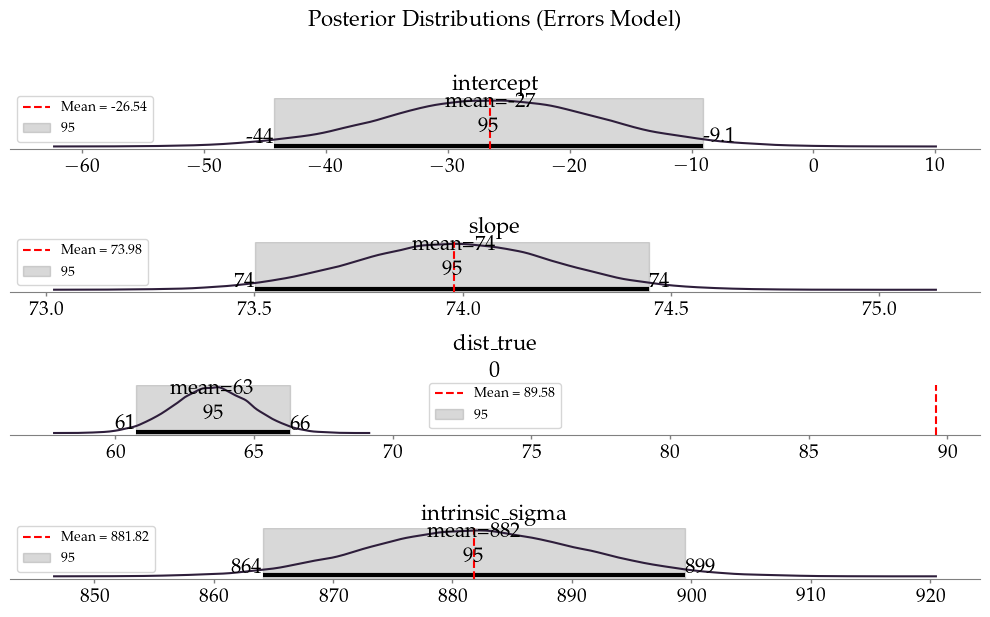

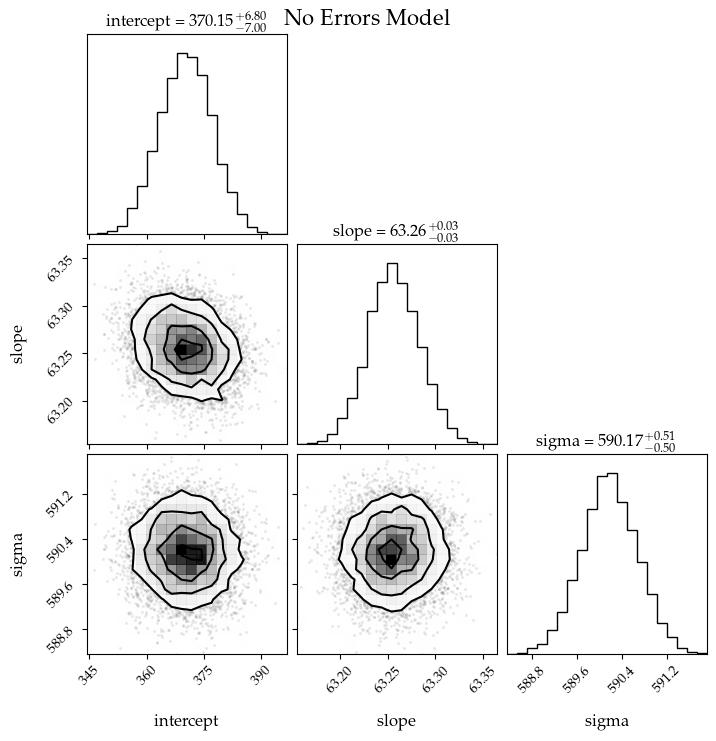

In [9]:
az.rcParams['plot.max_subplots'] = 100

def add_mean_and_ci(ax, trace, param_name):
    mean = trace.posterior[param_name].mean().values
    hdi = az.hdi(trace, hdi_prob=0.95)[param_name].values.flatten()
    ax.axvline(mean, color='red', linestyle='--', label=f"Mean = {mean:.2f}")
    ax.axvspan(hdi[0], hdi[1], color='gray', alpha=0.3, label=f"95% CI = [{hdi[0]:.2f}, {hdi[1]:.2f}]")
    ax.legend()

### POSTERIOR DISTRIBUTIONS: NO ERRORS
fig_no_errors, axes = plt.subplots(min(len(trace_no_errors.posterior.keys()), 20), 1, figsize=(10, 6), tight_layout=True)
for i, param_name in enumerate(trace_no_errors.posterior.keys()):
    if i >= len(axes): break
    az.plot_posterior(trace_no_errors, var_names=[param_name], ax=axes[i], hdi_prob=0.95)
    add_mean_and_ci(axes[i], trace_no_errors, param_name)
fig_no_errors.suptitle("Posterior Distributions (No Errors Model)", fontsize=16, y=1.02)

### POSTERIOR DISTRIBUTIONS: WITH ERRORS
fig_with_errors, axes = plt.subplots(min(len(trace_with_errors.posterior.keys()), 20), 1, figsize=(10, 6), tight_layout=True)
for i, param_name in enumerate(trace_with_errors.posterior.keys()):
    if i >= len(axes): break
    az.plot_posterior(trace_with_errors, var_names=[param_name], ax=axes[i], hdi_prob=0.95)
    add_mean_and_ci(axes[i], trace_with_errors, param_name)
fig_with_errors.suptitle("Posterior Distributions (Errors Model)", fontsize=16, y=1.02)

plt.show()

### CORNER PLOT: NO ERRORS
corner_data_no_errors = az.extract(trace_no_errors).to_dataframe()
corner.corner(
    corner_data_no_errors,
    labels=list(corner_data_no_errors.columns),
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
)
plt.suptitle("No Errors Model", fontsize=16)
plt.show()

In [ ]:
##### ATTENTION: DON'T RUN, IT WILL KILL KERNEL. NEEDS FIXING! ###

### CORNER PLOT: WITH ERRORS
corner_data_with_errors = az.extract(trace_with_errors).to_dataframe()
corner.corner(
    corner_data_with_errors,
    labels=list(corner_data_with_errors.columns),
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
)
plt.suptitle("Errors Model", fontsize=16)
plt.show()

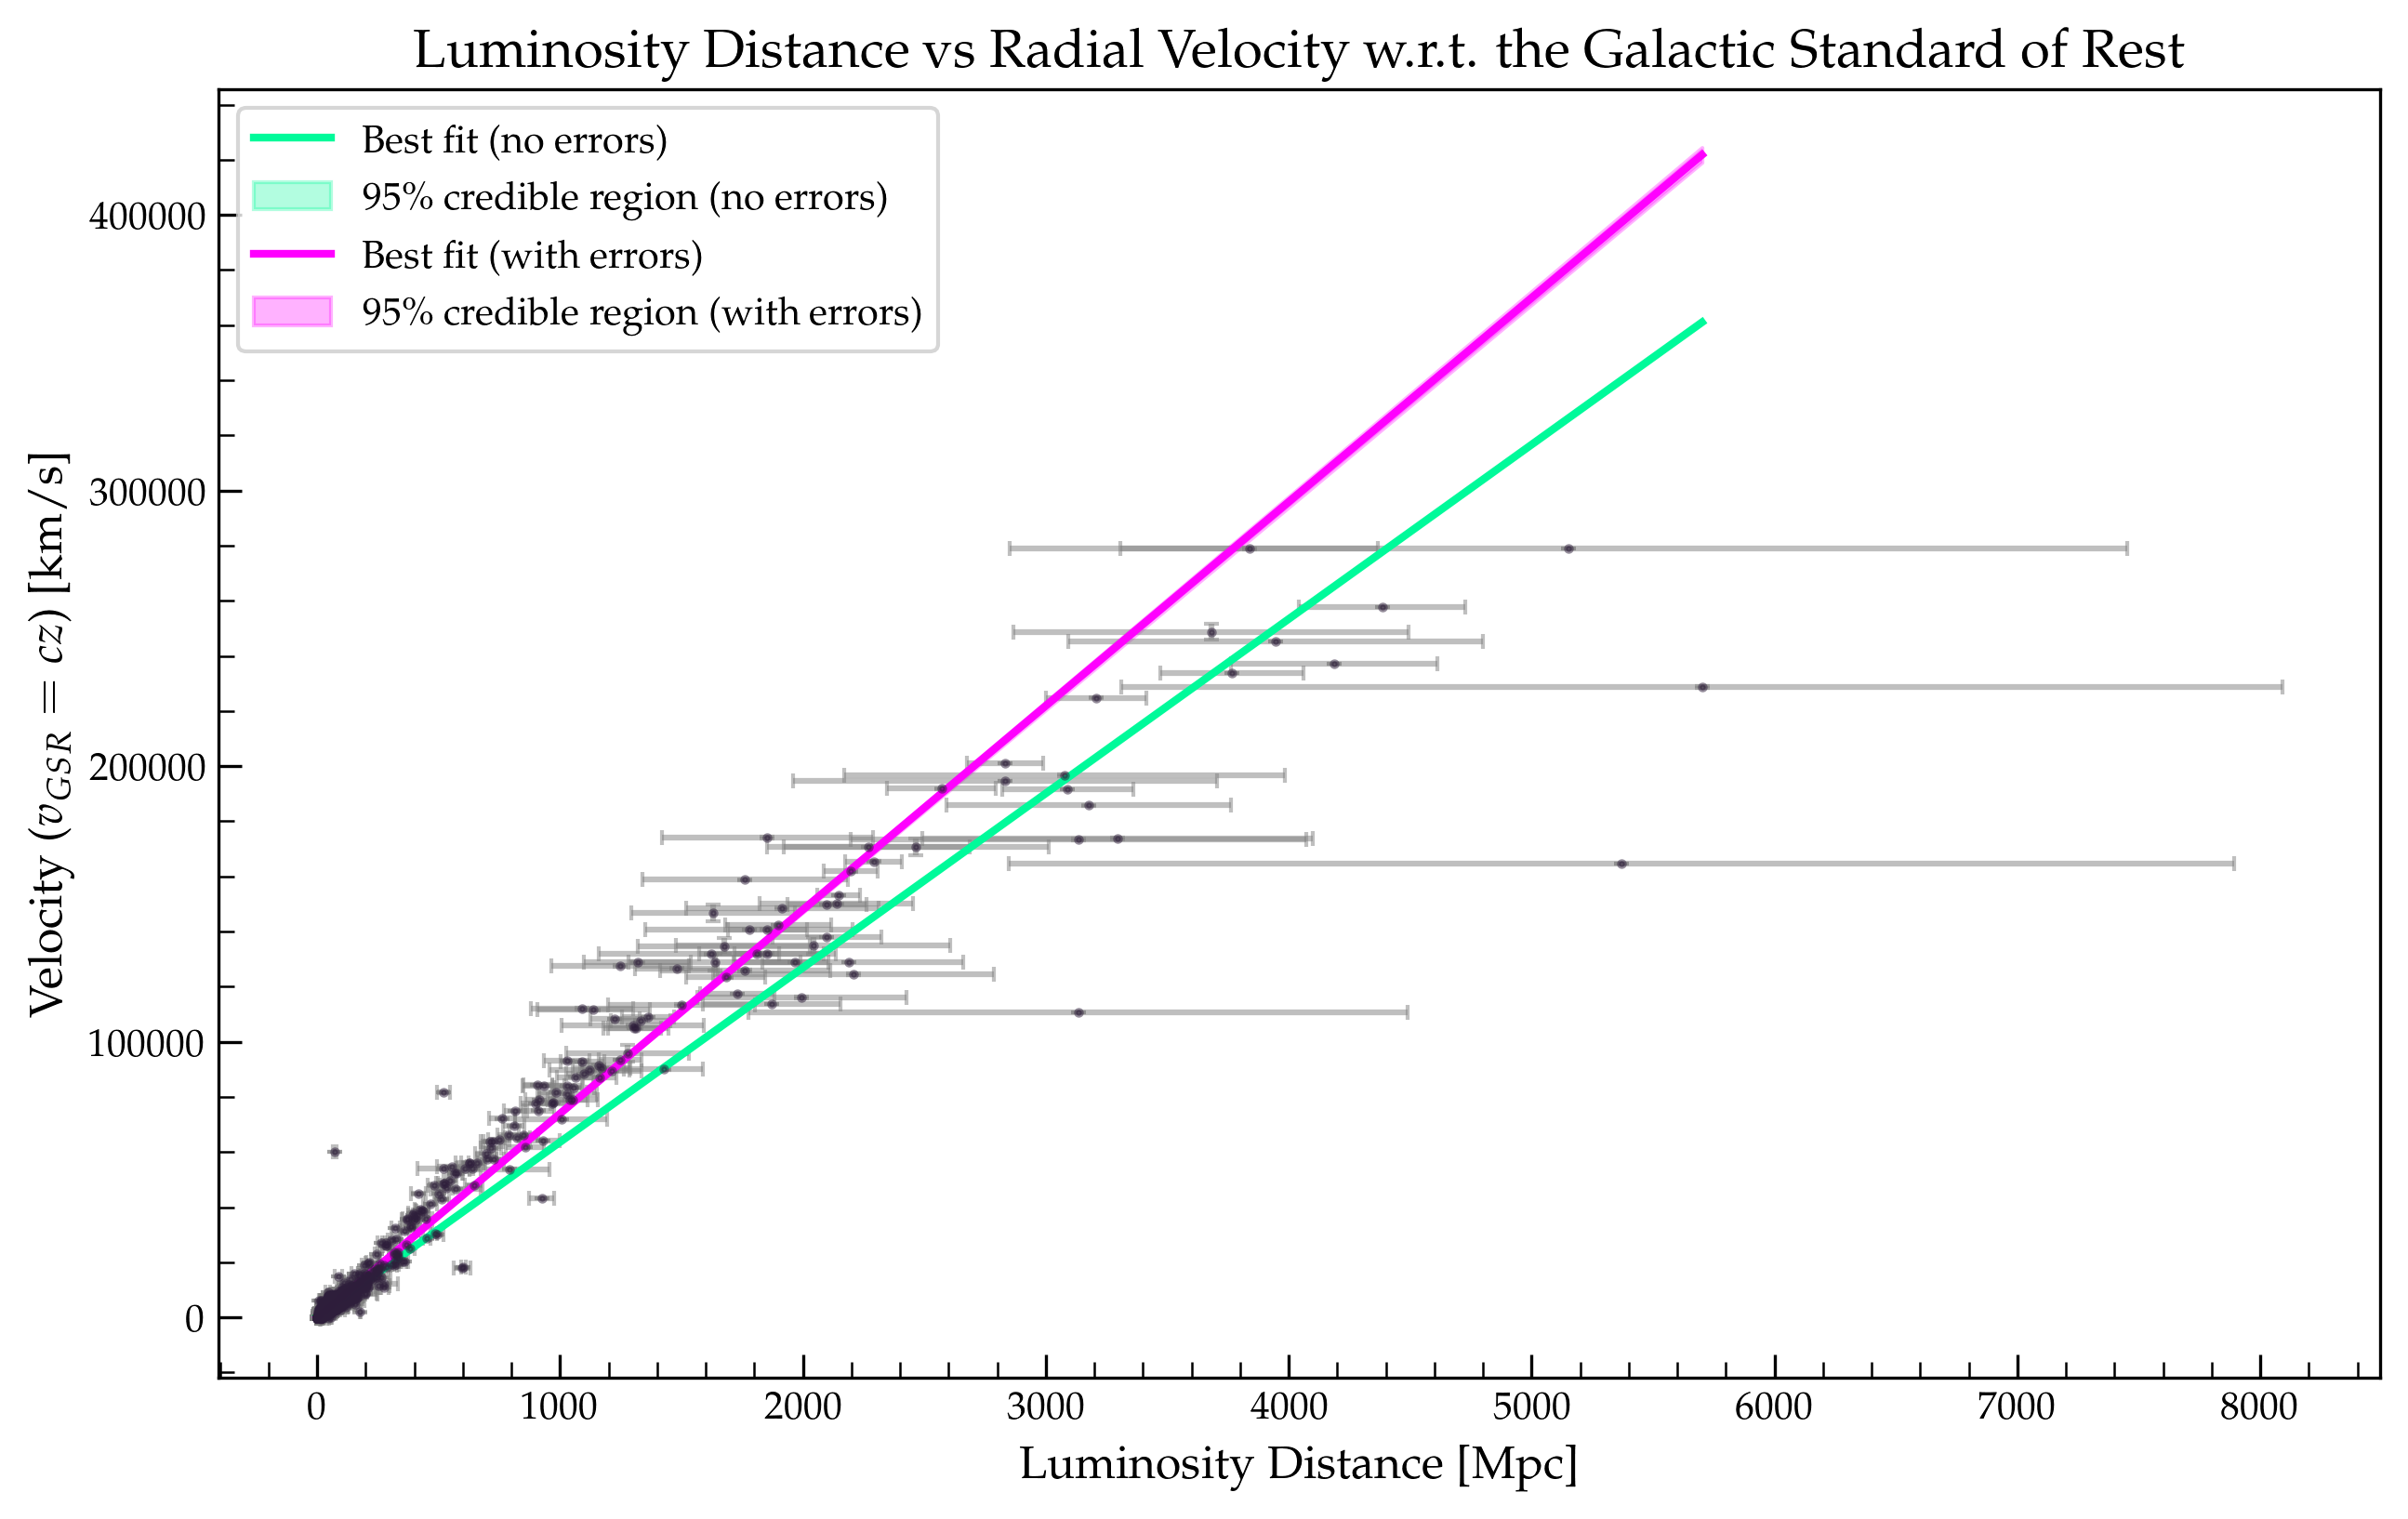

In [22]:
### EXTRACT POSTERIOR SAMPLES
intercept_no_errors = trace_no_errors.posterior['intercept'].values.flatten()
slope_no_errors = trace_no_errors.posterior['slope'].values.flatten()

intercept_with_errors = trace_with_errors.posterior['intercept'].values.flatten()
slope_with_errors = trace_with_errors.posterior['slope'].values.flatten()

### DISTANCES FOR PREDICTION
distance_range = np.linspace(data['distance_mpc'].min(), data['distance_mpc'].max(), 100)
distance_range_2d = distance_range[:, np.newaxis]

### COMPUTE PREDICTION FOR EACH POSTERIOR SAMPLE
predicted_no_errors = intercept_no_errors + slope_no_errors * distance_range_2d
predicted_with_errors = intercept_with_errors + slope_with_errors * distance_range_2d

### 0.95 CI
lower_no_errors = np.percentile(predicted_no_errors, 2.5, axis=1)
upper_no_errors = np.percentile(predicted_no_errors, 97.5, axis=1)
lower_with_errors = np.percentile(predicted_with_errors, 2.5, axis=1)
upper_with_errors = np.percentile(predicted_with_errors, 97.5, axis=1)

### GET LINES
best_fit_no_errors = np.mean(predicted_no_errors, axis=1)
best_fit_with_errors = np.mean(predicted_with_errors, axis=1)

### PLOTS
plt.figure(dpi = 300, figsize = (10,6))

plt.errorbar(data['distance_mpc'], data['vgsr'], 
             xerr=data['distance_error'], yerr=data['e_vgsr'], 
             fmt='.', markersize=3, alpha=0.5, ecolor='gray', capsize=2)

plt.plot(distance_range, best_fit_no_errors, color='mediumspringgreen', lw=2, label='Best fit (no errors)')
plt.fill_between(distance_range, lower_no_errors, upper_no_errors, color='mediumspringgreen', alpha=0.3,
                 label=r'95\% credible region (no errors)')

plt.plot(distance_range, best_fit_with_errors, color='magenta', lw=2, label='Best fit (with errors)')
plt.fill_between(distance_range, lower_with_errors, upper_with_errors, color='magenta', alpha=0.3,
                 label=r'95\% credible region (with errors)')

plt.title(r'Luminosity Distance vs Radial Velocity w.r.t. the Galactic Standard of Rest', fontsize=14)
plt.tick_params(axis='both', which='major', direction='in', length=6)
plt.tick_params(axis='both', which='minor', direction='in', length=4)
plt.minorticks_on()
plt.xlabel(r'Luminosity Distance [Mpc]', fontsize=12)
plt.ylabel(r'Velocity ($v_{GSR} = c z$) [km/s]', fontsize=12)
plt.legend()
plt.show()

## Model 3: Bayesian Linear Regression with properly distributed errors in log space
The first two blocks of code immediately following this are the set up for the emcee package to run this model, while the block below them actually runs the code.

In [8]:
# Functions for converting from distance modulus to luminosity distance and vice versa
# Convert from modulus to distance
def mod_to_dist(modulus):
    return 10**(modulus/5 - 5)
# Convert from distance to modulus
def dist_to_mod(dist):
    return 5*np.log10(dist) + 25

# Functions for computing log-probability of basic probability distributions
# Normal Distribution
def lnp_norm(x, mu, var):
    # Compute the exponential kernel of the normal distribution
    # We can ignore the constant of proportionality out front,
    # it just gives us an added constant to the log probability
    lnp = -(0.5/var)*((x-mu)**2)
    
    # Return sum of all of the elements of the above
    return np.sum(lnp)

# Gamma Distribution
def lnp_gamma(x, a, b):
    # Make sure x is a positive number
    if x <= 0:
        return -np.Inf
    
    # Compute log of the gamma distribution
    # Ignore constants of proportionality, only focus on factors including x
    lnp = (a-1)*np.log(x) - b*x

    # Return log probability
    return lnp

# Half-Normal Distribution
def lnp_halfnorm(x, var):
    # Toss if it is a negative number
    if x <= 0:
        return -np.Inf

    # If it's a positive number...
    # then it's treated the same as a normal distribution with mean 0
    return lnp_norm(x, 0, var)

# Total model likelihood for properly distributed errors
def lnp_model(params, x, y, xerr, yerr, mu0, mu1, v0, v1, vsigma):
    # Check how many parameters are passed to this function
    if len(params)==2:
        # If there's only 2, then we assume beta0 is fixed to 0
        b0 = 0
        # MCMC should generate beta1, lambda
        b1, lam = params
    else:
        # Otherwise, we assume that beta0 is allowed to vary
        # MCMC should generate beta0, beta1, lambda
        b0, b1, lam = params

    # Generate the "true" x's from normal distributions about observed x's
    # First, convert observed x's back to moduli
    xmod = dist_to_mod(x)
    # Generate true x's about these points
    xtrue = norm.rvs(xmod, xerr)
    # Then return to distance space
    xtrue = mod_to_dist(xtrue)

    # Compute the expected value for y from "true" x's
    xb = b0 + b1*xtrue

    # Compute the total variance
    vary = lam + (yerr**2)

    # Get log probabilities
    lny = lnp_norm(y, xb, vary) # Linear connection, total variance is sum of observed variance + model variance
    lnb0 = lnp_norm(b0, mu0, v0) # beta0 normal distribution
    lnb1 = lnp_norm(b1, mu1, v1) # beta1 normal distribution
    lnlam = lnp_halfnorm(lam, vsigma) # precision gamma distribution

    # Produce of probabilities is sum of logs
    lnp = lny + lnb0 + lnb1 + lnlam

    # Return log probability
    return lnp

In [31]:
# Choose parameters for running the emcee model
# Below we're setting up for 2 models, model A with intercept allowed to vary and model B with the intercept fixed to 0
# Also, prior distribution for slope is centered about 70
nwalkers = 100 # How many parallel MCMC chains are running
# Prep the data for the MCMC chains
x = data['distance_mpc'].values
xerr = data['e_mod0'].values
y = data['vgsr'].values
yerr = data['e_vgsr'].values
# Set up our priors:
# p = [mu0, mu1, v0, v1, vsigma]
# The inherent variance, sigma, is half-normal distributed with variance vsigma
vsigma=1;
# The beta parameters, beta0 and beta1, are normally distributed with mean and variance given by their respective mu and v
mu0 = 0; mu1 = 0;
v0 = 10; v1 = 10;
# Model A
MC_varA = [x, y, xerr, yerr, mu0, mu1, v0, v1, vsigma];
# Model B
mu1 = 70;
MC_varB = [x, y, xerr, yerr, mu0, mu1, v0, v1, vsigma];

# Initial guesses for beta0, beta1, and lambda
init_b0 = norm.rvs(0, 1, size=(nwalkers, 1))
init_b1 = norm.rvs(70, 10, size=(nwalkers, 1))
init_lam = np.abs(norm.rvs(0, 1, size=(nwalkers, 1)))

# Model A
ndimA = 3 # How many parameters are being fit
initA = np.concatenate((init_b0, init_b1, init_lam), axis=1) # Initial parameter guesses
samplerA = emcee.EnsembleSampler(nwalkers, ndimA, lnp_model, args=MC_varA) # Create the MCMC object
# Model B
ndimB = 2 # How many parameters are being fit
initB = np.concatenate((init_b1, init_lam), axis=1) # Initial parameter guesses
samplerB = emcee.EnsembleSampler(nwalkers, ndimB, lnp_model, args=MC_varB) # Create the MCMC object

In [10]:
# Run the MCMC chains
# First iterations are for burn in
numburn=800
print('Burn in sequence')
print("Model A")
burninA = samplerA.run_mcmc(initA, numburn, progress=True)
samplerA.reset()
print("Model B")
burninB = samplerB.run_mcmc(initB, numburn, progress=True)
samplerB.reset()

# Next, run the actual MCMC chains and look at the outputs
msim = 2500 # How many steps each MCMC chain takes
print("Model A")
outA = samplerA.run_mcmc(burninA, msim, progress=True);
print("Model B")
outB = samplerB.run_mcmc(burninB, msim, progress=True);

Burn in sequence
Model A


100%|██████████| 800/800 [00:20<00:00, 38.70it/s]


Model B


100%|██████████| 800/800 [00:19<00:00, 40.82it/s]


Model A


100%|██████████| 2500/2500 [01:02<00:00, 40.08it/s]


Model B


100%|██████████| 2500/2500 [01:02<00:00, 40.00it/s]


In [11]:
# Extract the information from the samplers
samplesA = samplerA.get_chain()
samplesB = samplerB.get_chain()

# Convert from precision to standard deviation
# samplesA[:, :, 2] = 1/np.sqrt(samplesA[:, :, 2])
# samplesB[:, :, 1] = 1/np.sqrt(samplesB[:, :, 1])

In [12]:
# Go back to regular matplotlib, since I don't know how to make the fancy plots work
# I think I'm missing a package or something, but I don't know what it is
rc('text', usetex=False)

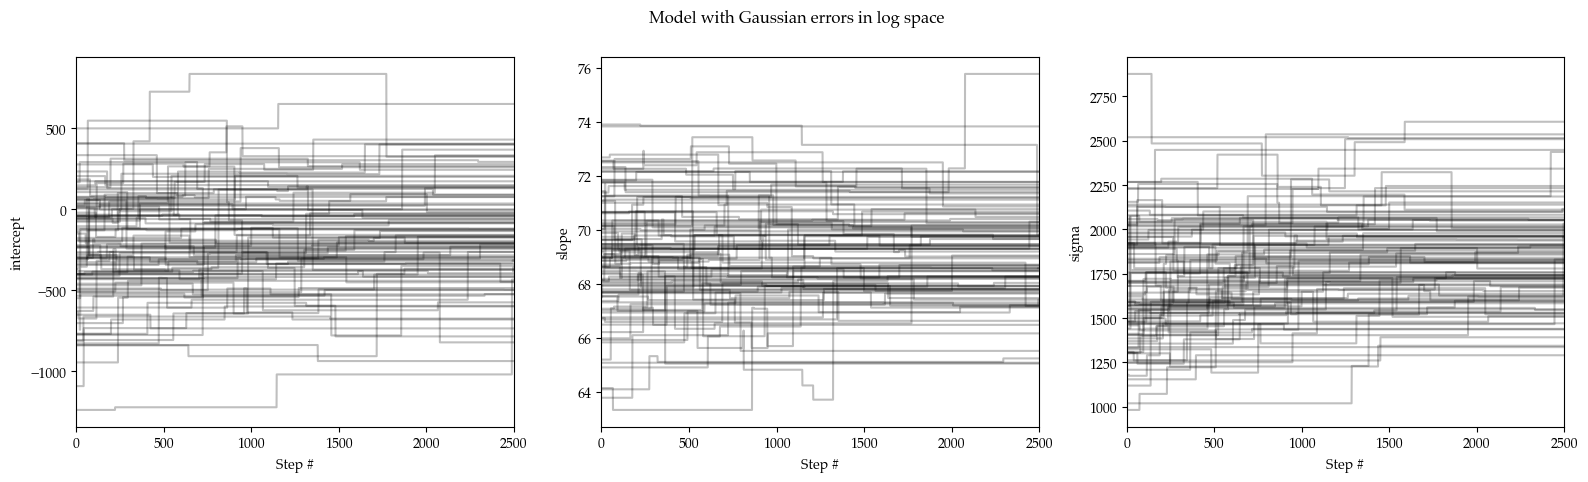

In [13]:
# Plot just the baseline prior
ncols=3
fig, axs = plt.subplots(ncols=ncols, nrows=1)
fig.set_figwidth(3*fig.get_figwidth())

# Add variable/MCMC chain labels
headers = ['Free Intercept', 'Fixed Intercept']
labels = ["intercept", "slope", "sigma"]

# Plotting time
# Iterate over variables
for i in range(ncols):
    # Plot each chain for Model A
    axs[i].plot(samplesA[:, :, i], color="black", alpha=0.25)
    axs[i].set_xlim(0, len(samplesA))
    axs[i].set_ylabel(labels[i])
    axs[i].set_xlabel("Step #");
        
# Label x axes and give column headers
fig.suptitle('Model with Gaussian errors in log space');

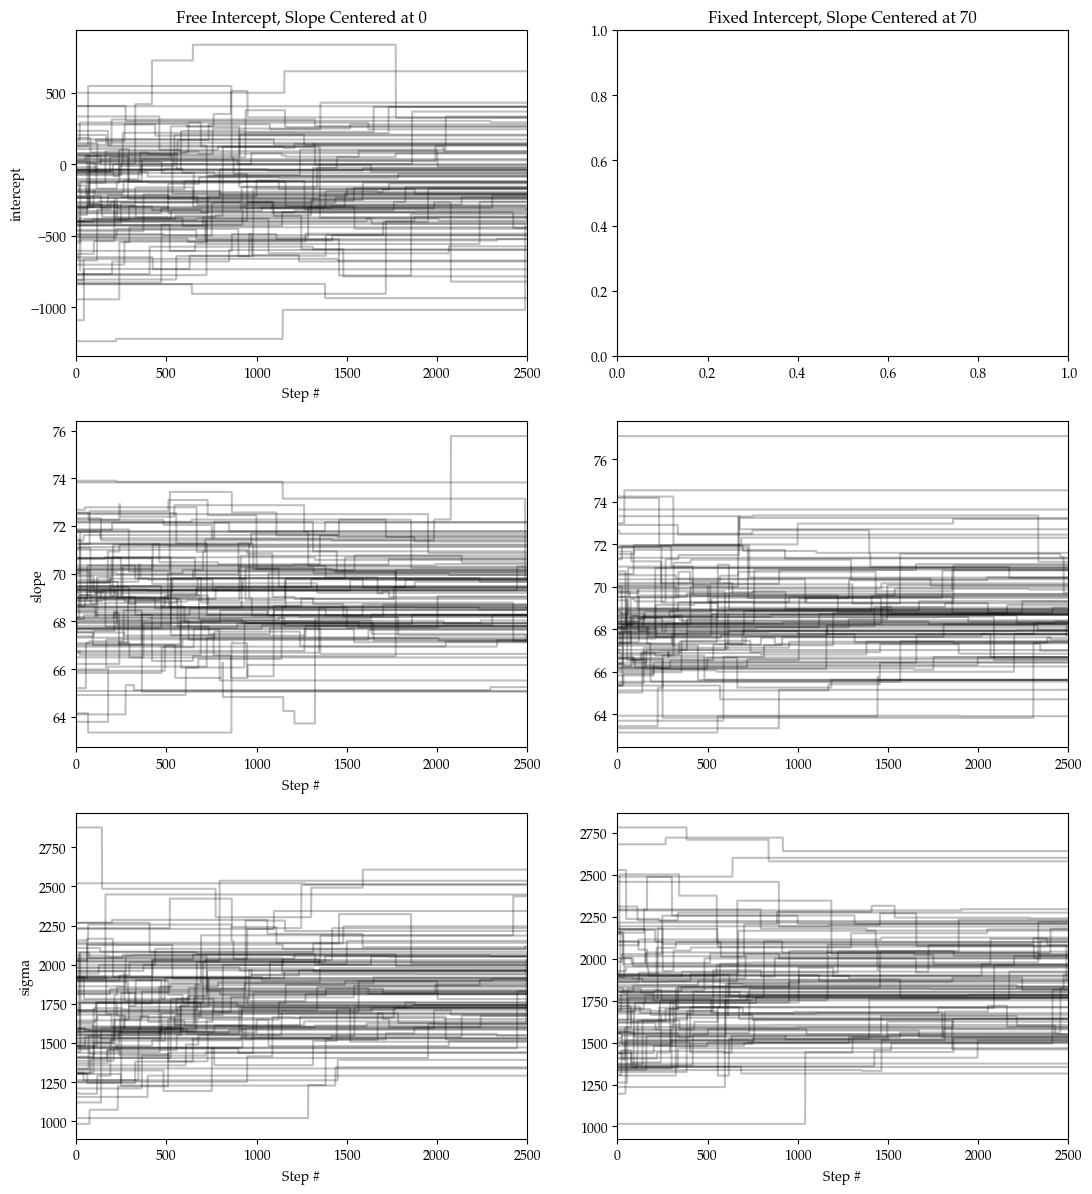

In [14]:
# Set up figure (nrows x ncols)
nrows=3
ncols=2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_figheight(nrows*fig.get_figheight())
fig.set_figwidth(ncols*fig.get_figwidth())

# Add variable/MCMC chain labels
headers = ['Free Intercept, Slope Centered at 0', 'Fixed Intercept, Slope Centered at 70']
labels = ["intercept", "slope", "sigma"]
# labels = [r"$\beta_0$", r"$\beta_1$", r"$\lambda$"]

# Plotting time
# Iterate over variables
for i in range(nrows):
    # Plot each chain for Model A
    axs[i,0].plot(samplesA[:, :, i], color="black", alpha=0.25)
    axs[i,0].set_xlim(0, len(samplesA))
    axs[i,0].set_ylabel(labels[i])
    axs[i,0].set_xlabel("Step #");

    # Skip beta0 for Model B
    if i!=0:
        axs[i,1].plot(samplesB[:, :, i-1], color="black", alpha=0.25)
        axs[i,1].set_xlim(0, len(samplesB))
        


# Label x axes and give column headers
axs[0,0].set_title(headers[0])
axs[0,1].set_title(headers[1])
axs[-1,0].set_xlabel("Step #");
axs[-1,1].set_xlabel("Step #");

In [15]:
# Compress all parallel MCMC chains into a single, unordered chain to be used for posterior generation
sampleA = np.reshape(samplesA, (msim*nwalkers, ndimA), order='F');
sampleB = np.reshape(samplesB, (msim*nwalkers, ndimB), order='F');

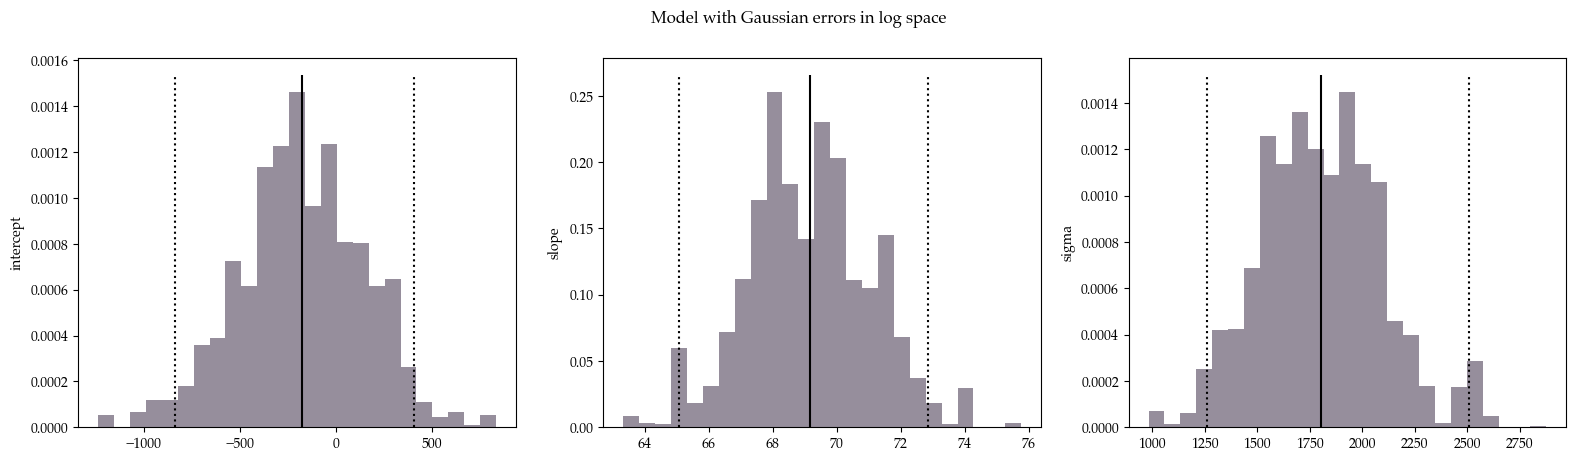

In [16]:
# Set up figure (nrows x ncols)=
nrows=3
fig, axs = plt.subplots(ncols=nrows, nrows=1)
fig.set_figwidth(3*fig.get_figwidth())

# Add variable/MCMC chain labels
labels = ["intercept", "slope", "sigma"]

# Plotting Time
# Iterate over variables
for i in range(nrows):
    # Plot histogram
    axs[i].hist(sampleA[:,i], density=True, bins=25, alpha=0.5);
    # Plot mean + 95% credible interval
    ylim = axs[i].get_ylim();
    axs[i].vlines(np.mean(sampleA[:,i]), ylim[0], ylim[1], color='black');
    axs[i].vlines([np.percentile(sampleA[:,i], 2.5), np.percentile(sampleA[:,i], 97.5)], ylim[0], ylim[1], color='black', linestyle='dotted');
    axs[i].set_ylabel(labels[i])

# Label x axes and give column headers
fig.suptitle('Model with Gaussian errors in log space');

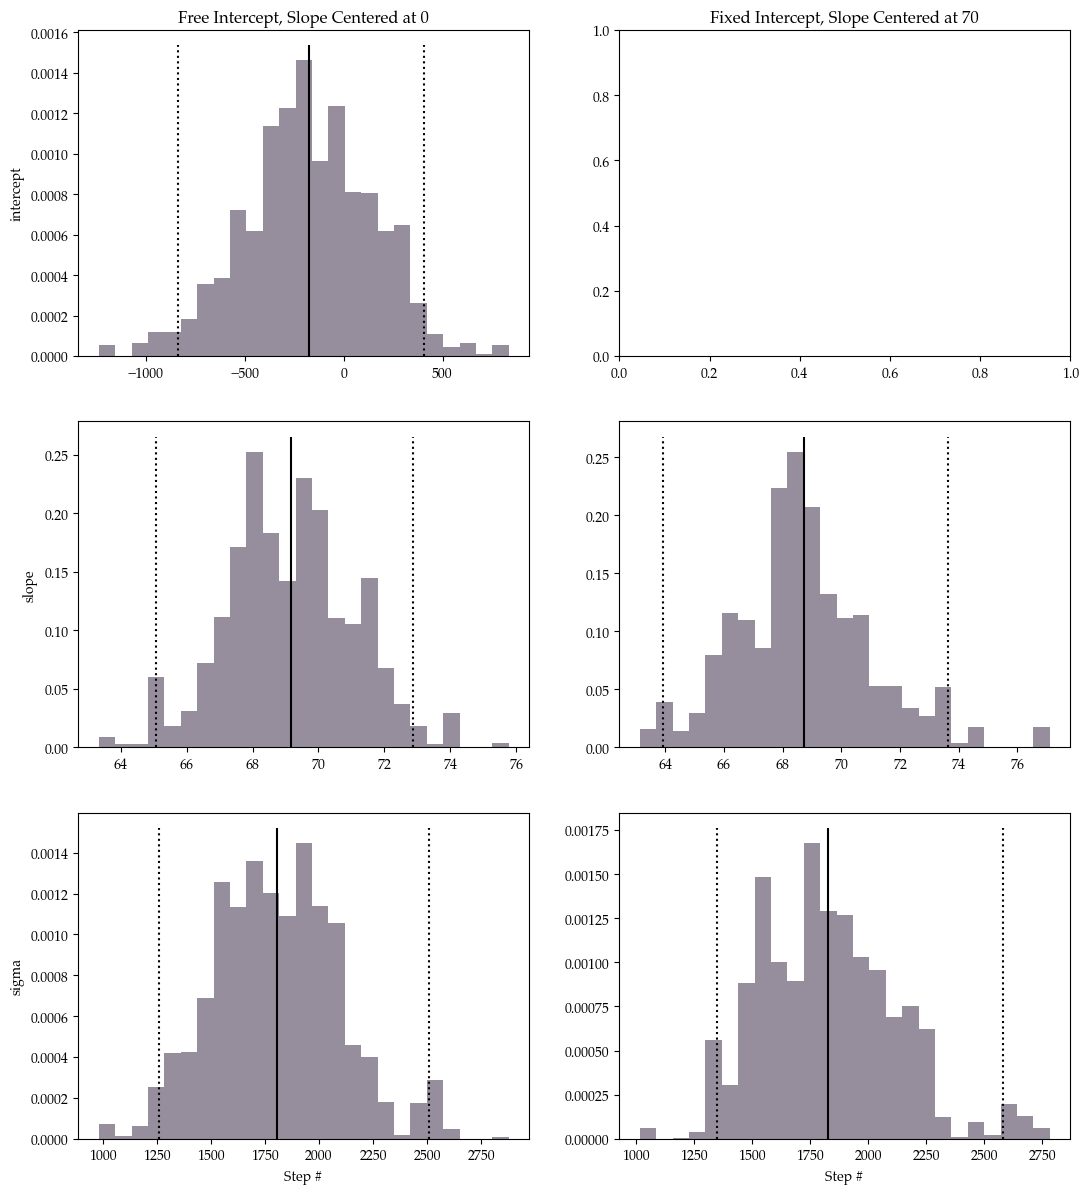

In [17]:
# Set up figure (nrows x ncols)
nrows=3
ncols=2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_figheight(nrows*fig.get_figheight())
fig.set_figwidth(ncols*fig.get_figwidth())

# Add variable/MCMC chain labels
headers = ['Free Intercept, Slope Centered at 0', 'Fixed Intercept, Slope Centered at 70']
labels = ["intercept", "slope", "sigma"]
# labels = [r"$\beta_0$", r"$\beta_1$", r"$\lambda$"]

# Plotting Time
# Iterate over variables
for i in range(nrows):
    # Plot histogram
    axs[i,0].hist(sampleA[:,i], density=True, bins=25, alpha=0.5);
    # Plot mean + 95% credible interval
    ylim = axs[i,0].get_ylim();
    axs[i,0].vlines(np.mean(sampleA[:,i]), ylim[0], ylim[1], color='black');
    axs[i,0].vlines([np.percentile(sampleA[:,i], 2.5), np.percentile(sampleA[:,i], 97.5)], ylim[0], ylim[1], color='black', linestyle='dotted');
    axs[i,0].set_ylabel(labels[i])

    # Skip beta0 for Model B
    if i!=0:
        axs[i,1].hist(sampleB[:, i-1], density=True, bins=25, alpha=0.5)
        ylim = axs[i,1].get_ylim();
        axs[i,1].vlines(np.mean(sampleB[:,i-1]), ylim[0], ylim[1], color='black');
        axs[i,1].vlines([np.percentile(sampleB[:,i-1], 2.5), np.percentile(sampleB[:,i-1], 97.5)], ylim[0], ylim[1], color='black', linestyle='dotted');

# Label x axes and give column headers
axs[0,0].set_title(headers[0])
axs[0,1].set_title(headers[1])
axs[-1,0].set_xlabel("Step #");
axs[-1,1].set_xlabel("Step #");

In [37]:
# Get the mean and 95% confidence interval bounds
hmean = np.mean(sampleA[:,1])
hlow = np.percentile(sampleA[:,1], 2.5)
hup = np.percentile(sampleA[:,1], 97.5)
intmean = np.mean(sampleA[:,0])
intlow = np.percentile(sampleA[:,0], 2.5)
intup = np.percentile(sampleA[:,0], 97.5)
hBmean = np.mean(sampleB[:,0])
hBlow = np.percentile(sampleB[:,0], 2.5)
hBup = np.percentile(sampleB[:,0], 97.5)

# Display them for reference
print(f'Mean H_0: {hmean}')
print(f'2.5% percentile: {hlow}')
print(f'97.5% percentile: {hup}')

Mean H_0: 69.16602433368536
2.5% percentile: 65.08307835077973
97.5% percentile: 72.87187638614766


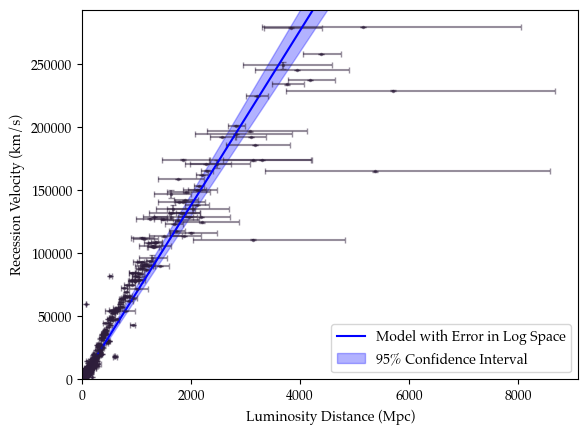

In [36]:
# Plot line of best fit on top of error bars
fig, ax = plt.subplots()

# First, compute the error bars on the distance
mod = np.array(data['mod0'].values)
emod = np.array(data['e_mod0'].values)
xup = mod_to_dist(mod+emod)-x
xlow = x-mod_to_dist(mod-emod)
dist_err = [xlow, xup]

# Plot the data points with error bars
ax.errorbar(x, y, xerr=dist_err, yerr=yerr, fmt='.', markersize=3, alpha=0.5, capsize=2)

# Set the lower limits on the axes to 0
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

# Get the x and y limits for later
xlims = ax.get_xlim();
ylims = ax.get_ylim();

# Compute an x vector
plotx = np.arange(0, xlims[1], 1)

# Compute the corresponding y vectors
ploty = intmean + hmean*plotx
ylow = intlow + hlow*plotx
yup = intup + hup*plotx

# Now we plot the lines and shade in the 95% confidence region
ax.plot(plotx, ploty, color='blue', label='Model with Error in Log Space')
ax.fill_between(plotx, ylow, yup, color='blue', label='95% Confidence Interval', alpha=0.3)

# Set the x and y limits back
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Add labels
ax.set_xlabel('Luminosity Distance (Mpc)')
ax.set_ylabel('Recession Velocity (km/s)')
ax.legend(loc='lower right');

In [ ]:
# Plot line of best fit on top of error bars
fig, ax = plt.subplots()

# First, compute the error bars on the distance
mod = np.array(data['mod0'].values)
emod = np.array(data['e_mod0'].values)
xup = mod_to_dist(mod+emod)-x
xlow = x-mod_to_dist(mod-emod)
dist_err = [xlow, xup]

# Plot the data points with error bars
ax.errorbar(x, y, xerr=dist_err, yerr=yerr, fmt='.', markersize=3, alpha=0.5, capsize=2)

# Set the lower limits on the axes to 0
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

# Get the x and y limits for later
xlims = ax.get_xlim();
ylims = ax.get_ylim();

# Compute an x vector
plotx = np.arange(0, xlims[1], 1)

# Compute the corresponding y vectors
ploty = intmean + hmean*plotx
ylow = intlow + hlow*plotx
yup = intup + hup*plotx
plotyB = hBmean*plotx
ylowB = hBlow*plotx
yupB = hBup*plotx

# Now we plot the lines and shade in the 95% confidence region
ax.plot(plotx, ploty, color='blue', label='Free Intercept, Slope Centered at 0')
ax.fill_between(plotx, ylow, yup, color='blue', label='95% Confidence Interval', alpha=0.3)
ax.plot(plotx, plotyB, color='lavender', label='Fixed Intercept, Slope Centered at 70')
ax.fill_between(plotx, ylowB, yupB, color='lavender', label='95% Confidence Interval', alpha=0.3)

# Set the x and y limits back
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Add labels
ax.set_xlabel('Luminosity Distance (Mpc)')
ax.set_ylabel('Recession Velocity (km/s)')
ax.legend(loc='lower right')